# Tutorial 4 - MIBR

## Artificial Neural Networks

Import and initialize

In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, auc, accuracy_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

Import data and convert as Pandas DataFrame

In [2]:
test_data = pd.read_csv('exoTest.csv').fillna(0)
train_data = pd.read_csv('exoTrain.csv').fillna(0)

In [3]:
test_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


In [4]:
train_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Data preprocessing (converting `LABEL` to binary and reducing memory)

In [5]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


More data processing: splitting and normalizing the data

In [6]:
#splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

Even more data processing: Applying Gaussian filter and scaling the features so that we don't worry about fluxes that are out of scale.

In [7]:
# Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

# Feature scaling -- after applying Gaussian filters, 
# make the Gaussian data have mean of 0 and variance of 1
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

Now to apply PCA so that we only use a fraction of the stars that will have the most effect on copying the dataset's variance.

53


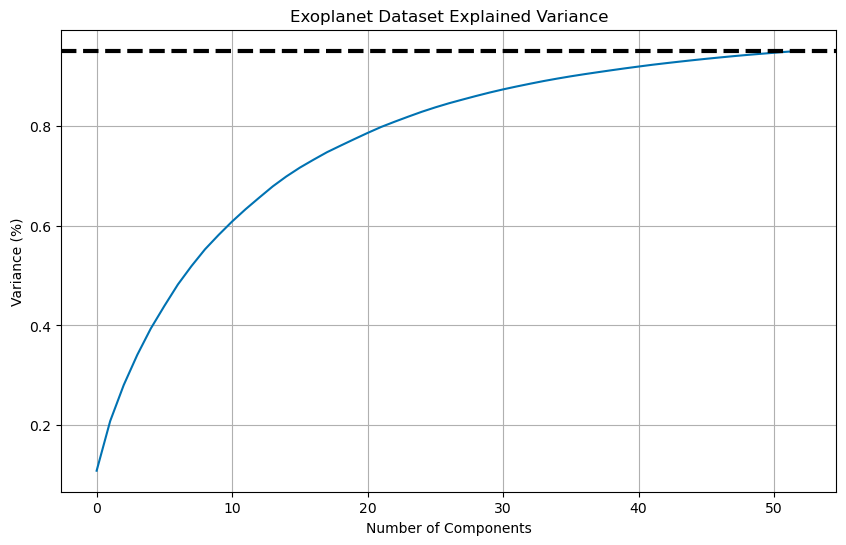

RangeIndex(start=0, stop=53, step=1)

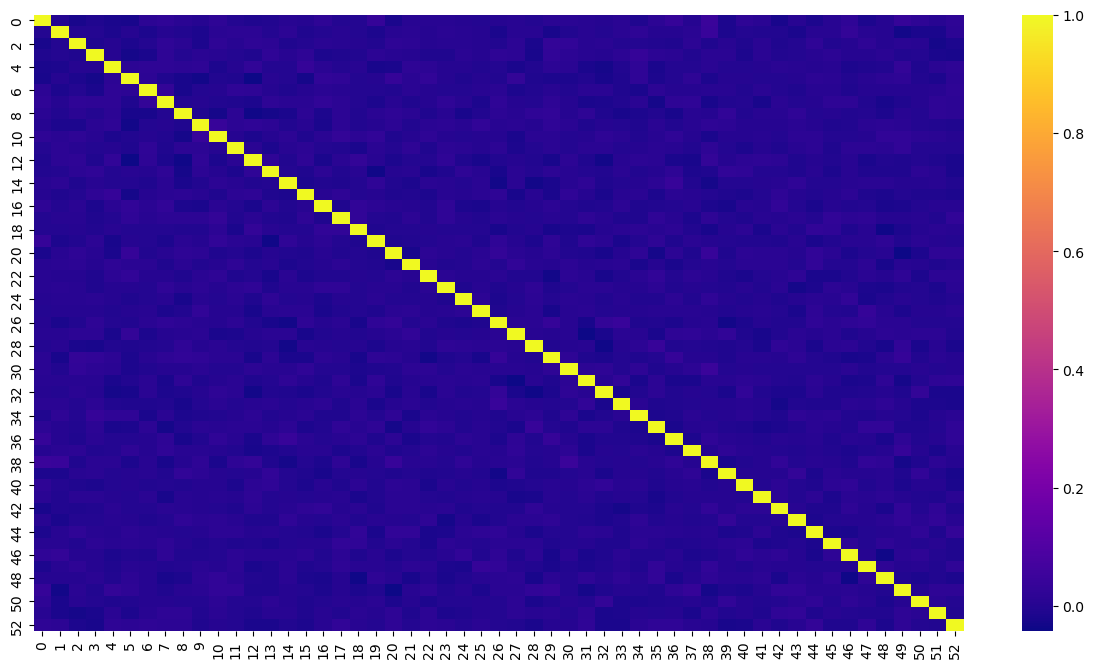

In [8]:
#Dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.95:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)
    
"""
This plot tells us that selecting 35 components we can preserve something around 98.8% or 99% 
of the total variance of the data. It makes sense, we’ll not use 100% of our variance,
because it denotes all components, and we want only the principal ones.
"""

#Apply PCA with n_componenets
pca = PCA(n_components=53)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, ls='--', c='k', lw=3)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.grid()
plt.show()
        
df = pd.DataFrame.from_records(x_train)     
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=False, cmap='plasma')
df.columns

In order to balance the dataset, we combine over- and under-sampling using the `imblearn` package's `SMOTEENN`, or "Synthetic Minority Oversampling TEchnqiue - Edited Nearest Neighbors". Here is a [sample](https://imbalanced-learn.org/stable/combine.html#combine) from their website.

In [9]:
#Resampling as the data is highly unbalanced.
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTEENN(random_state=27, sampling_strategy = 1.0, n_jobs=-1)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel()) 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5049


We then use `GridSearchCV` from `skl.model_selection` in order to get the architecture that would yield the most accurate score. This function does the 5-fold stratification (default) on the training dataset in order to calculate the average cross-validation estimate. In our case, we vary the optimizer of the model, the kernel initializer, and the number of epochs and batches. It took about 35 minutes to run this cell, so we just use its result.

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

def create_model(optimizer='adam', init='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=x_train_res.shape[1], kernel_initializer=init, activation='relu'))
    model.add(Dense(4, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
gridtrial = KerasClassifier(model=create_model, verbose=0)
print(gridtrial.get_params().keys())

# grid search epochs, batch size, kernel initializer, and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [10, 20, 40]
batches = [5, 10, 20]

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, model__init=init)

tic = time.time()
grid = GridSearchCV(estimator=gridtrial, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train_res, y_train_res)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
toc = time.time()
print("Elapsed time:", toc-tic)

We see from the result that the combination of parameters that give the most accurate result is `{'batch_size': 5, 'epochs': 10, 'model__init': 'glorot_uniform', 'optimizer': 'rmsprop'}`. We then apply this below to get the accuracy scores via `skl.model_selection.cross_val_score`.

Here, `glorot_uniform` "draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the number of output units)." -- [TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)

While "the gist of RMSprop is to: Maintain a moving (discounted) average of the square of gradients, Divide the gradient by the root of this average. This implementation of RMSprop uses plain momentum, not Nesterov momentum. The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance." -- [TensorFlow docs](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop)

In [10]:
#Artificial Neural Network
from tensorflow.random import set_seed
set_seed(42)

from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library

def build_classifier():
    classifier = Sequential() # initialize neural network, a Sequential API
    classifier.add(Dense(units = 4, kernel_initializer = 'glorot_uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'glorot_uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(model = build_classifier, epochs = 10, batch_size=5)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Cross-validation mean: "+ str(mean))
print("Cross-validation variance: "+ str(variance))

#Accuracy mean: 0.7791307791307792
#Accuracy variance: 0.26064381617895693

# Accuracy mean for sigmoid last layer: 0.9172277212142944
# Accuracy variance for sigmoid last layer: 0.08991406942298877

# Accuracy mean for softmax last layer: 0.49999999925494193
# Accuracy variance for softmax last layer: 0.44325030881539623

Accuracy mean: 0.9687128712871287
Accuracy variance: 0.025058308631811296


As a comparison, let's get the cross-validation score (same as above) of the `MLPClassifier` instance.

In [11]:
from sklearn.neural_network import MLPClassifier

trial = MLPClassifier(hidden_layer_sizes=(4,2), random_state=42)
trial.fit(x_train_res, y_train_res)
y_pred_trial = trial.predict(x_test)
print("Cross-validation mean: ", cross_val_score(trial, x_train_res, y_train_res, cv=5, n_jobs=-1).mean())
print("Cross-validation variance: ", cross_val_score(trial, x_train_res, y_train_res, cv=5, n_jobs=-1).std())

Cross-validation mean:  0.9414777926529652
Cross-validation variance:  0.009669394137138911


Comparing with the other classification methods:

- Validation accuracy of Logistic Regression is 0.6975697569756976
- Validation accuracy of KNN is 0.9834983498349835
- Validation accuracy of Decision Tree is 0.9426942694269427